In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## Produce synthetic data

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

/tmp/ipykernel_94498/3870500906.py:76: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid.T), cmap='viridis', vmax=np.log(1e1), vmin=np.log(1e-1))


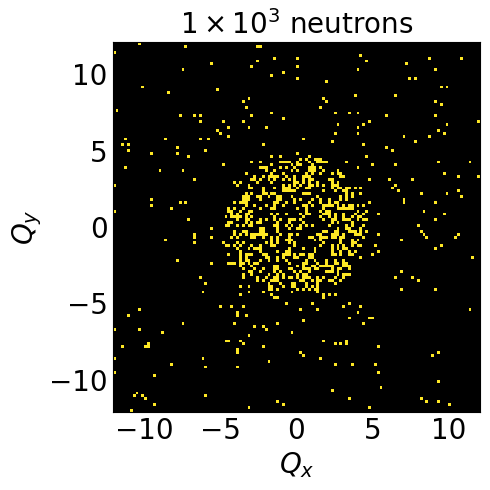

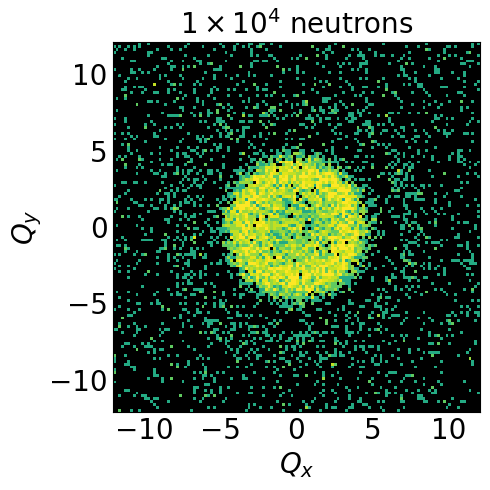

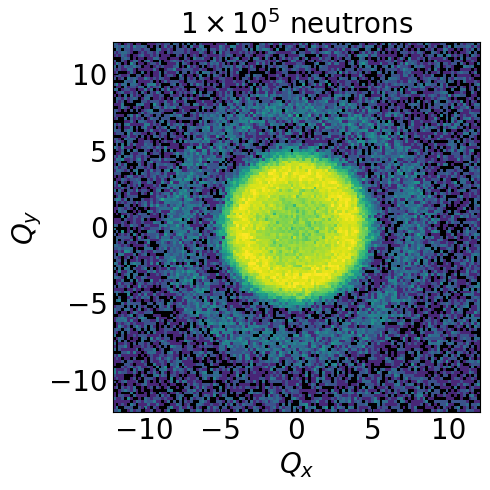

In [3]:
n_sample_list = np.array([1000, 10000, 100000])

q_grid = np.linspace(-12, 12, 128)
n_grid = len(q_grid)**2
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 5e-3
p_qxy = P_hs(q_rad*1.5)*S_hs(q_rad*1.5, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)


for n_sample in n_sample_list:
    #### generate random samples
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
    d_bins = bin_edges[1] - bin_edges[0]
    q = q_grid[q_grid > 0]

    def f_I_q(n_sample, p_qxy, seed =1145141):
        np.random.seed(seed)
        n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

        # Flatten the arrays
        qx_flat = qx.flatten()
        qy_flat = qy.flatten()
        p_qxy_flat = p_qxy.flatten()

        # Normalize the probability density
        p_qxy_flat /= p_qxy_flat.sum()

        # Randomly choose indices based on the probability density
        indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

        # Get the sampled qx and qy values
        qx_samples = qx_flat[indices]
        qy_samples = qy_flat[indices]

        # evaluate the sampled point density in each grid

        I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

        return I_q_grid

    def f_I_q_rad(I_q_grid, q):
        # evaluate the radial averaged density
        q = q_grid[q_grid > 0]
        I_q = np.zeros_like(q)
        sum_q = np.zeros_like(q)
        n_pixels_q = np.zeros_like(q)
        I_pixels_q = []
        for i in range(len(q)):
            mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
            I_pixels = I_q_grid[mask]
            sum_q[i] = I_pixels.sum()
            n_pixels_q[i] = mask.sum()
            I_q[i] = I_pixels.mean()
            
            I_pixels_q.append(I_pixels)
            
            
        return I_q, sum_q, n_pixels_q, I_pixels_q

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_grid = I_q_grid*n_grid/n_sample
    
    # Plot the sampled point density
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    ax.pcolormesh(qx, qy, np.log(I_q_grid.T), cmap='viridis', vmax=np.log(1e1), vmin=np.log(1e-1))
    # ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis', vmax=5, vmin=0)
    ax.set_xlabel(r'$Q_x$', fontsize=20)
    ax.set_ylabel(r'$Q_y$', fontsize=20)
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_title(f'${n_sample:.0e}$ neutrons'.replace('e+0', r'\times 10^'), fontsize=20)
    ax.set_facecolor('k')
    plt.tight_layout()


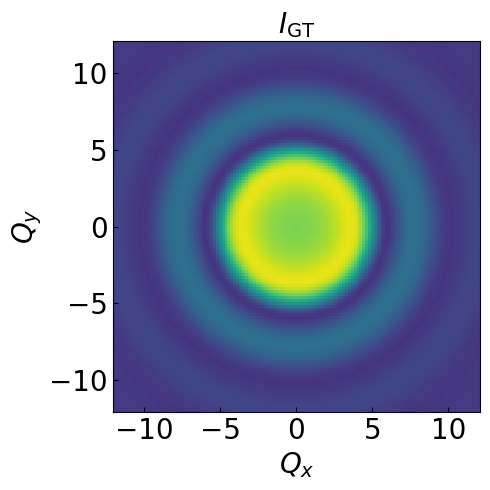

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_qxy*n_grid), cmap='viridis', vmax=np.log(1e1), vmin=np.log(1e-1))
# ax.pcolormesh(qx, qy, p_qxy*n_grid, cmap='viridis', vmax=5, vmin=0)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(r'$I_\mathrm{GT}$', fontsize=20)
ax.set_facecolor('k')
plt.tight_layout()



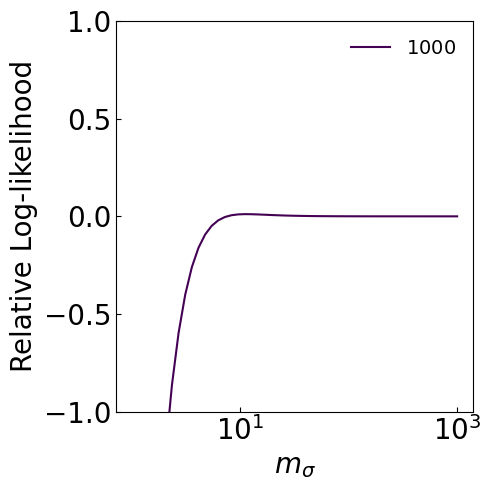

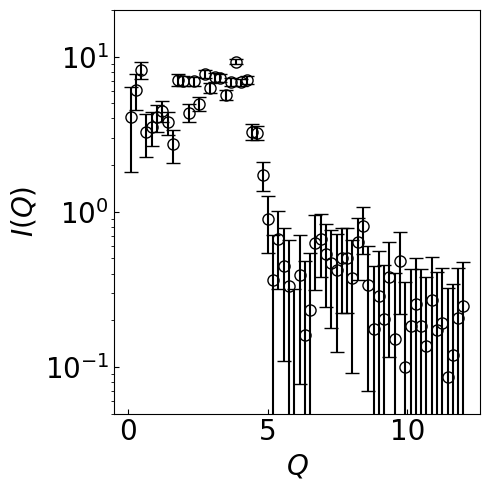

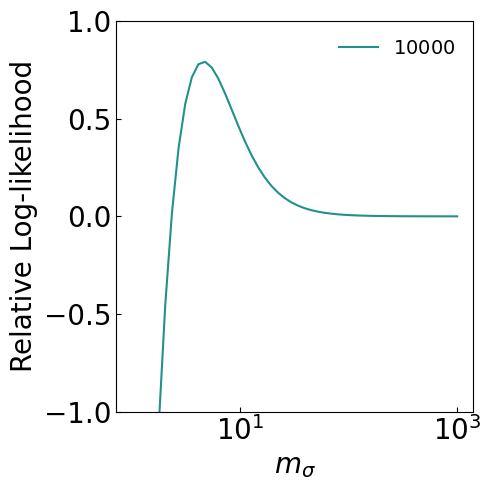

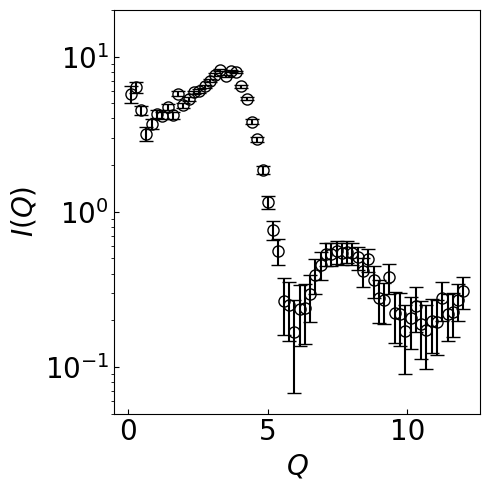

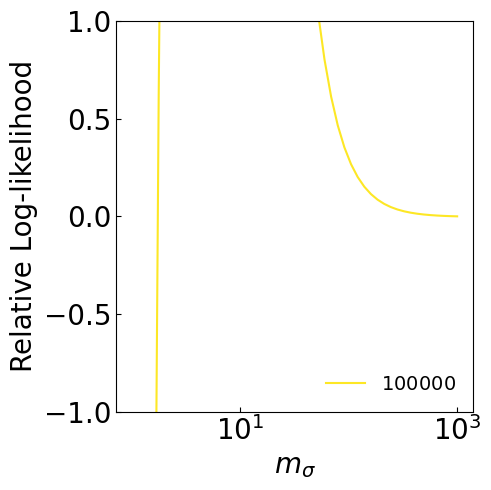

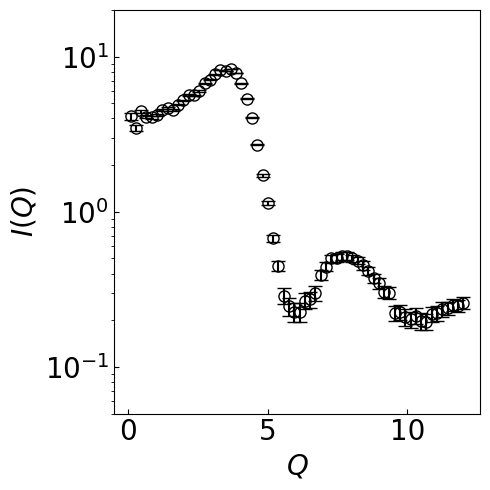

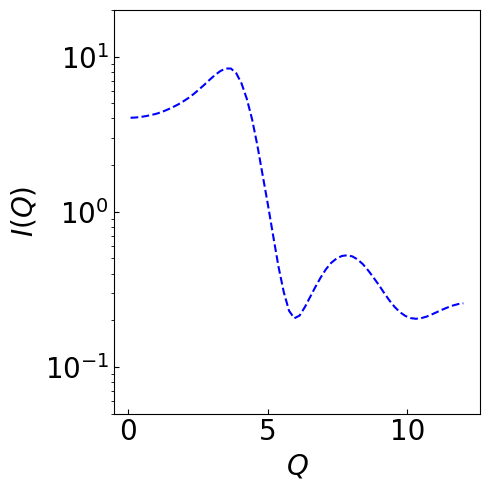

In [12]:
n_trial = 1
filter_size = 0.4
I_bg = 5e-3
# plot the log likelihood as a function of sigma

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = np.array([1000, 10000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    
    # #override I_q by given y_err
    # y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
    # # np.random.seed(seed_trial)
    # I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
    # # np.random.seed(None)
    
    I_q_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_q_gf[i] = (np.sum((I_q+I_bg)*weight_list)-I_bg)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q
        y_bg = I_q_gf
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1/n_sample*n_grid
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*y_err**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    if n_sample == 5000:
        color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-1, 1])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
    ax.legend(frameon=False, fontsize=14, ncol=2)
    plt.tight_layout()

    # # GPR with best sigma
    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*y_err**2
    std_s = np.sqrt(var_s)
    
    # plot the GPR result
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)

    ax.plot(q_x, y + y_bg, 'ok', alpha=1, markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$') 
    ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=1)
    # ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
    # ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    # ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

    # ax.plot(q_x, y_bg, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([5e-2, 2e1])
    # ax.set_ylim([-3, 6.5])

    # ax.legend(frameon=False, fontsize=16)
    plt.tight_layout()
    
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([-3, 6.5])

# ax.legend(frameon=False, fontsize=16)
plt.tight_layout()



/tmp/ipykernel_94498/3544361714.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(sigma_list[np.argmax(log_likelihood_list)], log_likelihood_list[np.argmax(log_likelihood_list)], 'ro', color=color, ms=18, fillstyle='none')
/tmp/ipykernel_94498/3544361714.py:179: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs" (-> color='r'). The keyword argument will take precedence.
  ax.plot(sigma_list[np.argmax(log_likelihood_list)], log_likelihood_list[np.argmax(log_likelihood_list)], 'rs', color='r', ms=12, fillstyle='none', markeredgewidth=2)


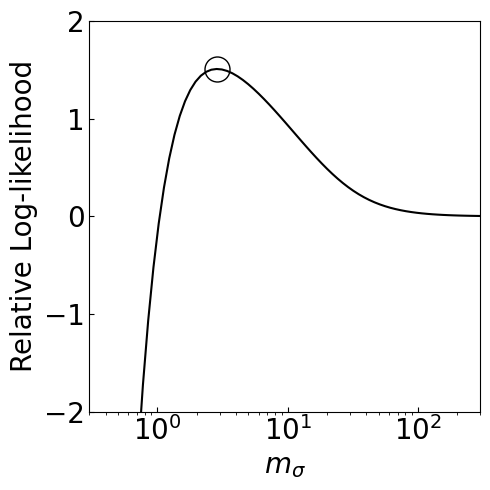

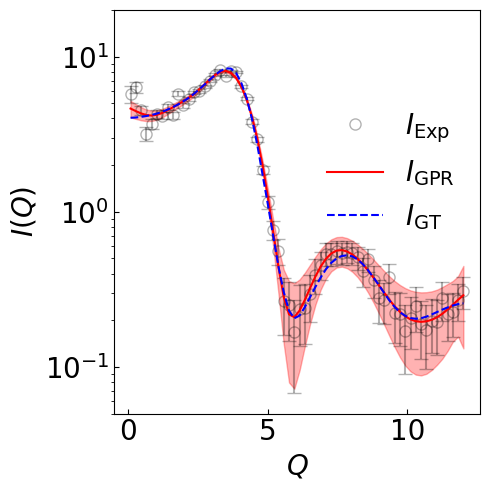

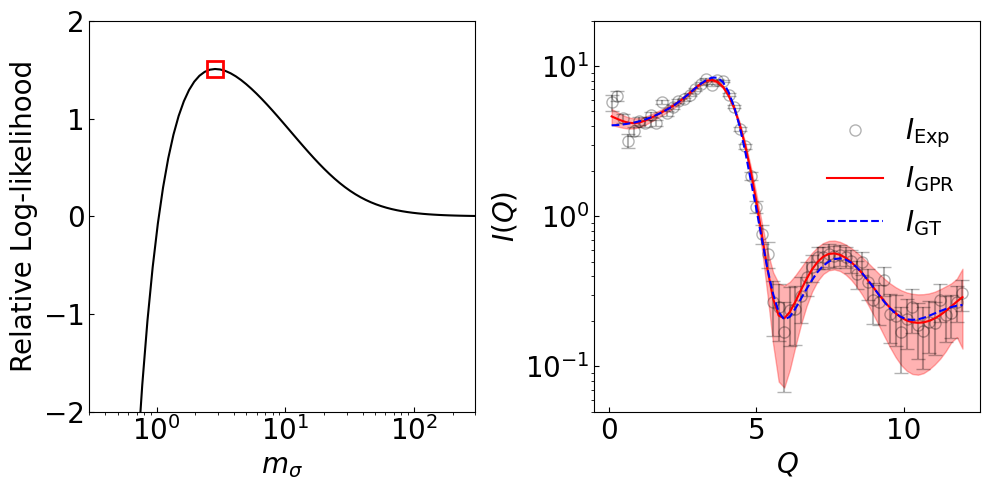

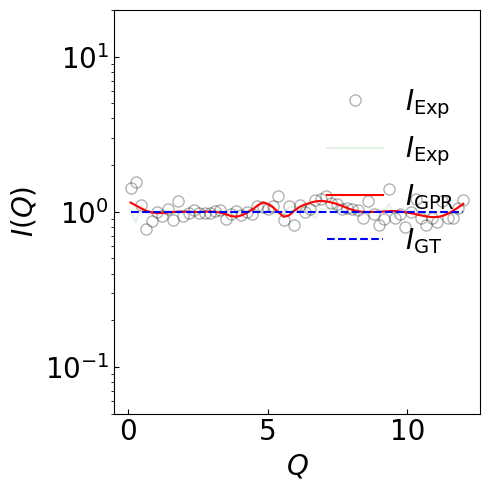

In [10]:
n_trial = 1
filter_size = 0.8
I_bg = 5e-3
# plot the log likelihood as a function of sigma

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = np.array([10000])
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    
    n_sample = int(n_sample)
    color = "k"
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    
    # #override I_q by given y_err
    # y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
    # # np.random.seed(seed_trial)
    # I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
    # # np.random.seed(None)

    I_q_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_q_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

    ## GPR
    sigma_list = np.logspace(-1, 3, 100)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q
        y_bg = I_q_gf
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1/n_sample*n_grid
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*sig_var
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    if n_sample == 5000:
        color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.plot(sigma_list[np.argmax(log_likelihood_list)], log_likelihood_list[np.argmax(log_likelihood_list)], 'ro', color=color, ms=18, fillstyle='none')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-2, 2])
    ax.set_xlim([0.3,300])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
    # ax.legend(frameon=False, fontsize=14, ncol=2)
    plt.tight_layout()

    # # GPR with best sigma
    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*sig_var
    std_s = np.sqrt(var_s)
    
    # plot the GPR result
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)

    ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
    ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
    ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
    ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

    # ax.plot(q_x, y_bg, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([5e-2, 2e1])
    # ax.set_ylim([0, 5])

    ax.legend(frameon=False, fontsize=20, loc='right', bbox_to_anchor=(1, 0.6))
    plt.tight_layout()
    
    # combined plot
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.plot(sigma_list[np.argmax(log_likelihood_list)], log_likelihood_list[np.argmax(log_likelihood_list)], 'rs', color='r', ms=12, fillstyle='none', markeredgewidth=2)
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-2, 2])
    ax.set_xlim([0.3,300])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)
    
    ax = plt.subplot(1, 2, 2)
    ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
    ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
    ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
    ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

    # ax.plot(q_x, y_bg, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([5e-2, 2e1])
    # ax.set_ylim([0, 5])

    ax.legend(frameon=False, fontsize=20, loc='right', bbox_to_anchor=(1, 0.6))
    
    # ax.legend(frameon=False, fontsize=14, ncol=2)
    plt.tight_layout()
    
    # # plot the GPR result
    # fig = plt.figure(figsize=(5, 5))
    # ax = plt.subplot(1, 1, 1)
    
    # y_gpr = mu_s + y_bg
    # y_data = y + y_bg
    # y_ref = y_gt
    
    # ax.plot(q_x, y_data/y_ref, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
    # ax.errorbar(q_x, y_data/y_ref, yerr=y_err*y_data/y_ref, fmt='none', ecolor='k', capsize=5, alpha=0.3)
    # ax.plot(q_s, y_gpr/y_ref, '-r', label=r'$I_\mathrm{GPR}$')
    # ax.fill_between(q_s, (y_gpr/y_ref)*(1-std_s), (y_gpr/y_ref)*(1+std_s), color='r', alpha=0.3)

    # ax.plot(q, y_gt/y_ref, '--b', label=r'$I_\mathrm{GT}$')

    # # ax.plot(q_x, y_bg/y_ref, '-g')

    # ax.set_xlabel(r'$Q$', fontsize=20)
    # ax.set_ylabel(r'$I(Q)/I_\mathrm{GT}(Q)$', fontsize=20)

    # ax.tick_params(direction='in', labelsize=20)
    # # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_ylim([0.2, 5.0])
    # # ax.set_ylim([0, 5])

    # ax.legend(frameon=False, fontsize=20)
    # plt.tight_layout()

# exp data with equivalent error
n_sample = 100000

dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2

I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
I_q_th = I_q_th*n_sample

# #override I_q by given y_err
# y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
# # np.random.seed(seed_trial)
# I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
# # np.random.seed(None)

I_q_gf = np.zeros_like(q)
for i in range(len(q)):
    weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
    weight_list = weight_list/np.sum(weight_list)
    I_q_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)

I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

## GPR
sigma_list = np.logspace(-1, 3, 100)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    ## define kernel function
    y_data_1 = I_q
    y_bg_1 = I_q_gf
    y_gt_1 = I_q_th
    y_1 = y_data_1-y_bg_1

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err_1 = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1/n_sample*n_grid
    y_bg_1 = y_bg_1*m_factor
    y_gt_1 = y_gt_1*m_factor
    y_1 = y_1*m_factor
    y_err_1 = y_err_1*m_factor
    y_data_1 = y_data_1*m_factor
    sig_var_1 = np.mean(y_1**2)
    
I_gpr = (mu_s + y_bg)
I_gpr_err = std_s

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, (y + y_bg)/y_gt, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
# ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_x, (y_1 + y_bg_1)/y_gt, 'g-', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.1) 
# ax.errorbar(q_x, y_1 + y_bg_1, yerr=y_err_1, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, I_gpr/y_gt, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, I_gpr - I_gpr_err, I_gpr + I_gpr_err, color='r', alpha=0.3)

ax.plot(q, y_gt/y_gt , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5e-2, 2e1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=20, loc='right', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

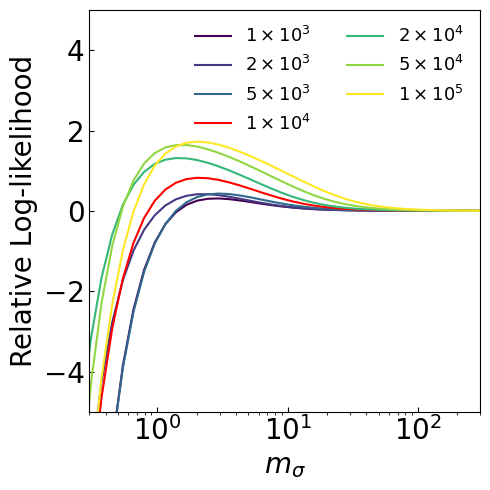

In [7]:
n_trial = 1
filter_size = 0.4
I_bg = 5e-3
# plot the log likelihood as a function of sigma

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)
    
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_q_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

    ## GPR
    sigma_list = np.logspace(-1, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q
        y_bg = I_q_gf
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1/n_sample*n_grid
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    if n_sample == 10000:
        color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-5, 5])
    ax.set_xlim([3e-1, 3e2])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
    ax.legend(frameon=False, fontsize=13, ncol=2)
    plt.tight_layout()

#     # # GPR with best sigma
#     # f_q = lambda q: np.log(q)
#     f_q = lambda q: q
#     f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
#     K_sigma = np.diag(f_y_err(y_err))
#     # K_sigma = sigma**2*np.eye(len(q_x))
#     K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
#     K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
#     k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

#     L = np.linalg.cholesky(K_xx)
#     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
#     v = np.linalg.solve(L, K_xs)
#     mu_s = K_xs.T @ alpha
#     cov_s = k_ss - v.T @ v
#     var_s = np.diag(cov_s)*y_err**2
#     std_s = np.sqrt(var_s)
    
#     # plot the GPR result
#     fig = plt.figure(figsize=(5, 5))
#     ax = plt.subplot(1, 1, 1)

#     ax.plot(q_x, y + y_bg, 'ok', alpha=1, markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$') 
#     ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=1)
#     # ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
#     # ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

#     # ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

#     # ax.plot(q_x, y_bg, '-g')

#     ax.set_xlabel(r'$Q$', fontsize=20)
#     ax.set_ylabel(r'$I(Q)$', fontsize=20)

#     ax.tick_params(direction='in', labelsize=20)
#     # ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylim([5e-2, 1e1])
#     # ax.set_ylim([-3, 6.5])

#     # ax.legend(frameon=False, fontsize=16)
#     plt.tight_layout()
    
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

# # ax.plot(q_x, y_bg, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 1e1])
# ax.set_ylim([-3, 6.5])

# # ax.legend(frameon=False, fontsize=16)
# plt.tight_layout()



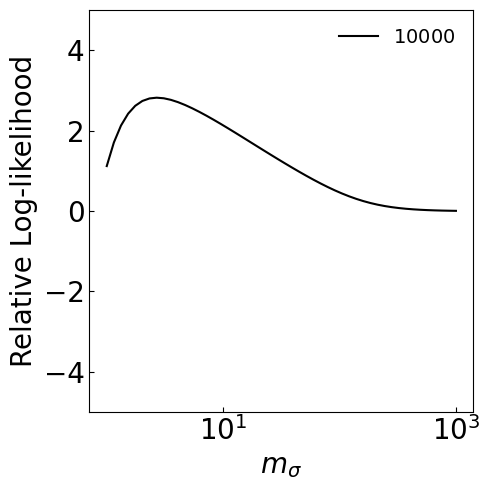

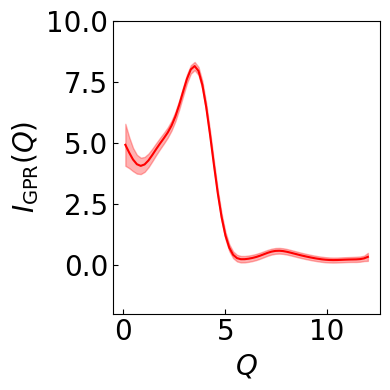

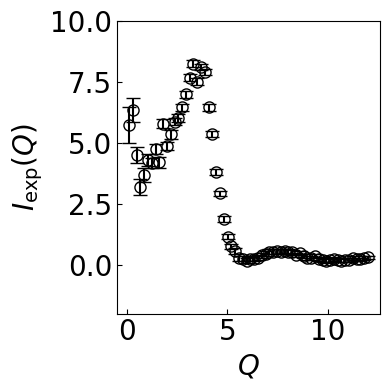

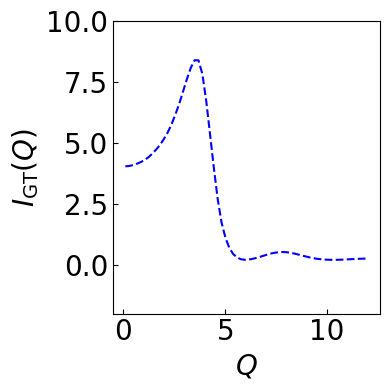

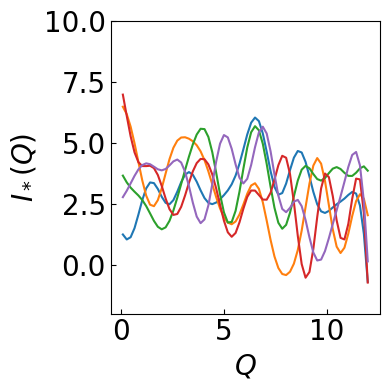

In [8]:
n_trial = 1
filter_size = 1
I_bg = 5e-3
# plot the log likelihood as a function of sigma

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = np.array([10000])
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    
    n_sample = int(n_sample)
    color = 'k'
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2

    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_q_gf[i] = (np.sum((I_q+I_bg)*weight_list)-I_bg)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q
        y_bg = I_q_gf
        y_bg = np.ones_like(y_bg)*2
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q)/np.maximum(n_pixels_q,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1/n_sample*n_grid
        y_bg = y_bg*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

    if n_sample == 5000:
        color = 'r'
    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-5, 5])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
    ax.legend(frameon=False, fontsize=14, ncol=2)
    plt.tight_layout()

    # # GPR with best sigma
    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)
    
    mu_s_rand_list = []
    for i in range(5):
        alpha_rand = np.linalg.solve(L.T, np.linalg.solve(L, np.random.normal(np.zeros_like(alpha), np.std(y))))
        mu_s_rand = K_xs.T @ alpha_rand
        mu_s_rand_list.append(mu_s_rand)
    
    # plot the GPR result
    fig = plt.figure(figsize=(4, 4))
    ax = plt.subplot(1, 1, 1)

    # ax.plot(q_x, y + y_bg, 'ok', alpha=1, markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$') 
    # ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=1)
    ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
    ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    # ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

    # ax.plot(q_x, y_bg, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I_\mathrm{GPR}(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_ylim([5e-2, 2e1])
    ax.set_ylim([-2, 10])
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
    
    # ax.legend(frameon=False, fontsize=16)
    plt.tight_layout()
    
    # plot the GPR result
    fig = plt.figure(figsize=(4, 4))
    ax = plt.subplot(1, 1, 1)

    ax.plot(q_x, y + y_bg, 'ok', alpha=1, markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$') 
    ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=1)
    # ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
    # ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

    # ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

    # ax.plot(q_x, y_bg, '-g')

    ax.set_xlabel(r'$Q$', fontsize=20)
    ax.set_ylabel(r'$I_\mathrm{exp}(Q)$', fontsize=20)

    ax.tick_params(direction='in', labelsize=20)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_ylim([5e-2, 2e1])
    ax.set_ylim([-2, 10])
    ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

    # ax.legend(frameon=False, fontsize=16)
    plt.tight_layout()
    
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I_\mathrm{GT}(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
ax.set_ylim([-2, 10])
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

# ax.legend(frameon=False, fontsize=16)
plt.tight_layout()


# plot the prior
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

# ax.fill_between(q_s, np.ones_like(q_s)*np.sqrt(sig_var)+ y_bg, -np.ones_like(q_s)*np.sqrt(sig_var)+ y_bg, color='r', alpha=0.3)
color_list = ['C0', 'C1', 'C2', 'C3', 'C4']
for i_rand, mu_s_rand in enumerate(mu_s_rand_list):
    ax.plot(q_s, mu_s_rand + y_bg, '-', color=color_list[i_rand], label=r'$I_\mathrm{GPR}$')
    # ax.fill_between(q_s, mu_s_rand - std_s + y_bg, mu_s_rand + std_s + y_bg, color=color_list[i_rand], alpha=0.3)

# ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I_*(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([5e-2, 2e1])
ax.set_ylim([-2, 10])
ax.set_position([pos.x0, pos.y0, pos.width*0.9, pos.height])

plt.tight_layout()
